In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
try:
    hoomd_device = hoomd.device.GPU(notice_level=3)
    
except RuntimeError:
    hoomd_device = hoomd.device.CPU(notice_level=3)

In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 39795


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes)

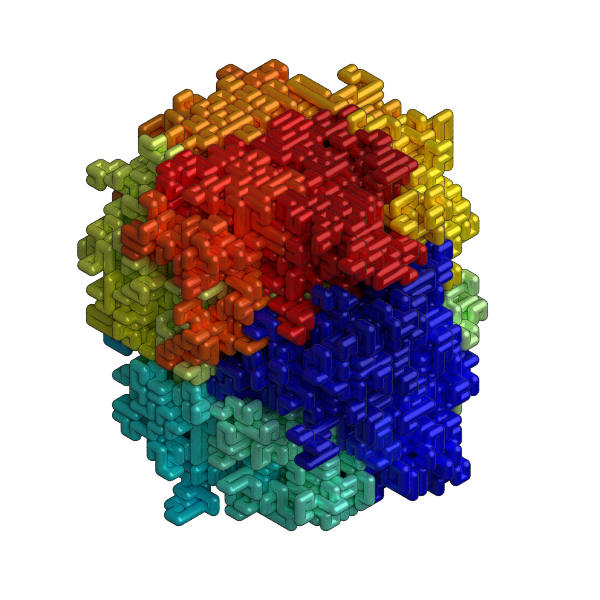

In [10]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, pathtrace=True, cmap="jet")

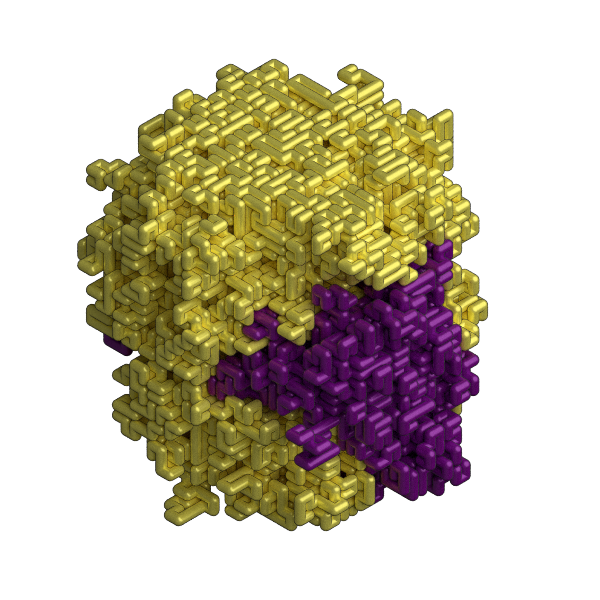

In [11]:
# Render individual chromosomes
render.fresnel(snapshot, pathtrace=True, show_chromosomes=True)

In [12]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [13]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [14]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "KG"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 5.0,
                    "B": 5.0
                },
                "B": {
                    "A": 5.0,
                    "B": 5.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [15]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [16]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [17]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [18]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces

In [19]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [20]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [21]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1000))

In [22]:
# Run
system.run(1e4)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       1000            110.74999      0:01:21.264117           1.02968          
       2000            115.95740      0:01:08.990855           1.03277          
       3000            118.07571      0:00:59.283999           1.02089          
       4000            119.24552      0:00:50.316357           1.01948          
       5000            119.94323      0:00:41.686386           1.01159          
       6000            120.52353      0:00:33.188539           1.02257          
       7000            120.85554      0:00:24.823025           1.03256          
       8000            121.16627      0:00:16.506244           1.01436          
       9000            121.33568      0:00:08.241599           1.02218          
       10000           121.47610         0:00:00               1.02445          


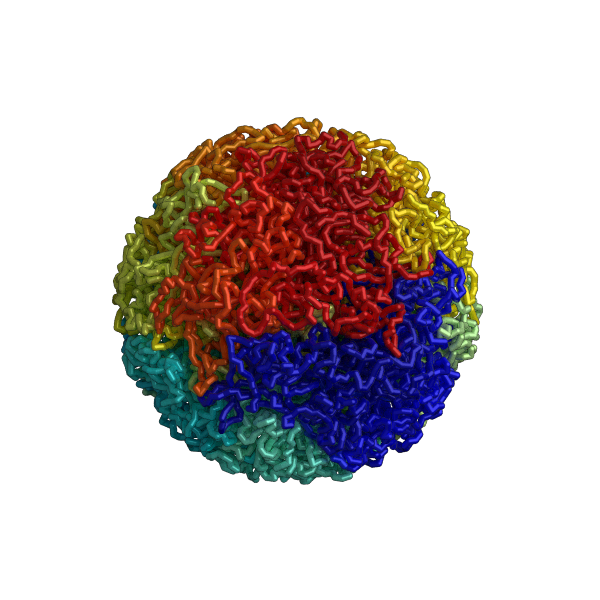

In [23]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, pathtrace=True, cmap="jet")

In [24]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

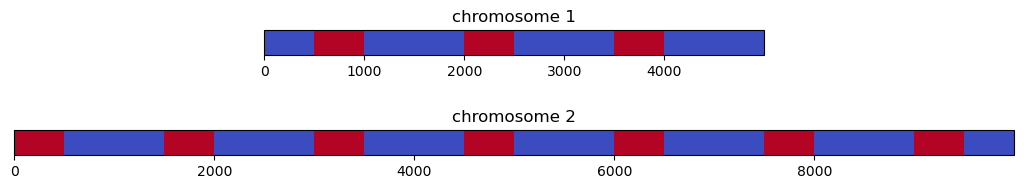

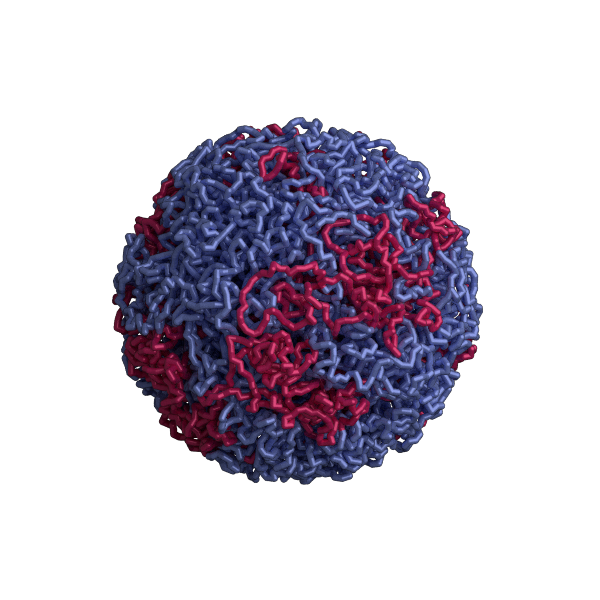

In [25]:
# Assign and visualize domains in 1D/3D
snapshot_relaxed.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot_relaxed, cmap="coolwarm")
render.fresnel(snapshot_relaxed, pathtrace=True, show_compartments=True, cmap="coolwarm")

In [26]:
# Load updated snapshot
system.state.set_snapshot(snapshot_relaxed)

In [27]:
# Set a pseudo square well attraction force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0.2
        }
    },
    "Type": "Polychrom"
}

In [28]:
# Update force field, including a DPD thermostat
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

force_field += attraction_forces + dpd_forces

In [29]:
# Setup new DPD integrator
system.operations.remove(integrator)
system.operations.remove(system.operations.writers[0])

nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/Users/mtortora/software/miniconda3/envs/polychrom-hoomd/lib/python3.11/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [30]:
# Update simulation engine
system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=1000))

In [31]:
# Run
system.run(1e4)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       11000           199.99568      0:00:45.000973           1.09823          
       12000           197.08573      0:00:40.591472           1.09206          
       13000           194.79584      0:00:35.935059           1.09261          
       14000           193.73413      0:00:30.970279           1.08212          
       15000           193.21435      0:00:25.877996           1.07503          
       16000           192.39235      0:00:20.790847           1.06865          
       17000           191.61215      0:00:15.656628           1.07925          
       18000           190.99383      0:00:10.471542           1.06840          
       19000           190.68045      0:00:05.244376           1.06924          
       20000           190.25035         0:00:00               1.06859          


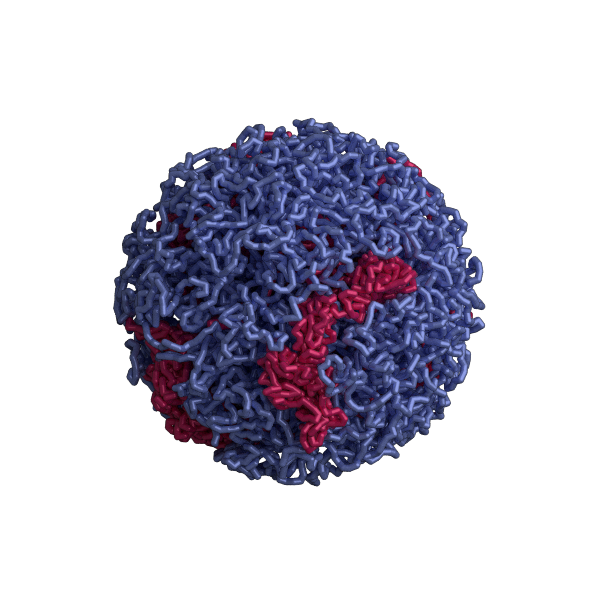

In [32]:
# Visualize new conformation
snapshot_collapsed = system.state.get_snapshot()
render.fresnel(snapshot_collapsed, pathtrace=True, show_compartments=True, cmap="coolwarm")